ESCI 895- Final Project- Mississippi River Annual Sediment Deposition 
Amelea Hauer 
October 2025 

MIT License

Copyright (c) 2025 Amelea Hauer

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Introduction: This final project is on the Mississippi River's estimated annual sediment deposition into the Gulf of Mexico. In the project, data analysis will be done using python coding to estimate annual sediment flux from the Mississippi river into the Gulf of Mexico with data taken at the USGS Baton Rouge monitoring station. Analyses of ... will be done to explore the answer to the previously asked question. This project has applicability to the world outside of just python, that being the coastline of of Louisiana and surrounding states in the Gulf of Mexico. The depsoition and reworking of sediments is crucial in preserving the shoreline from erosional processes (high-energy beach environments, storm-surge, precipitation/storm outwash, etc.). The artifical levees of the Mississippi have helped to prevent flooding events along the Mississppi River, but have in turn disconnected and decreased floodplains and their elevation, impacted river velocity, and sediment transport. Therefore, the natural process of the river has been changed overtime and studying the sediment deposition has improtant links to the ecosystem, natural habitats/coastline, and antropogenic factors. 

Research Question: What the is annual average sediment flux into the Gulf of Mexico from the Mississippi River? 

Study Site: 
    Region: Mississippi River into the Gulf of Mexico
        Data Collection site: Baton Roue, LA
        Insert map : 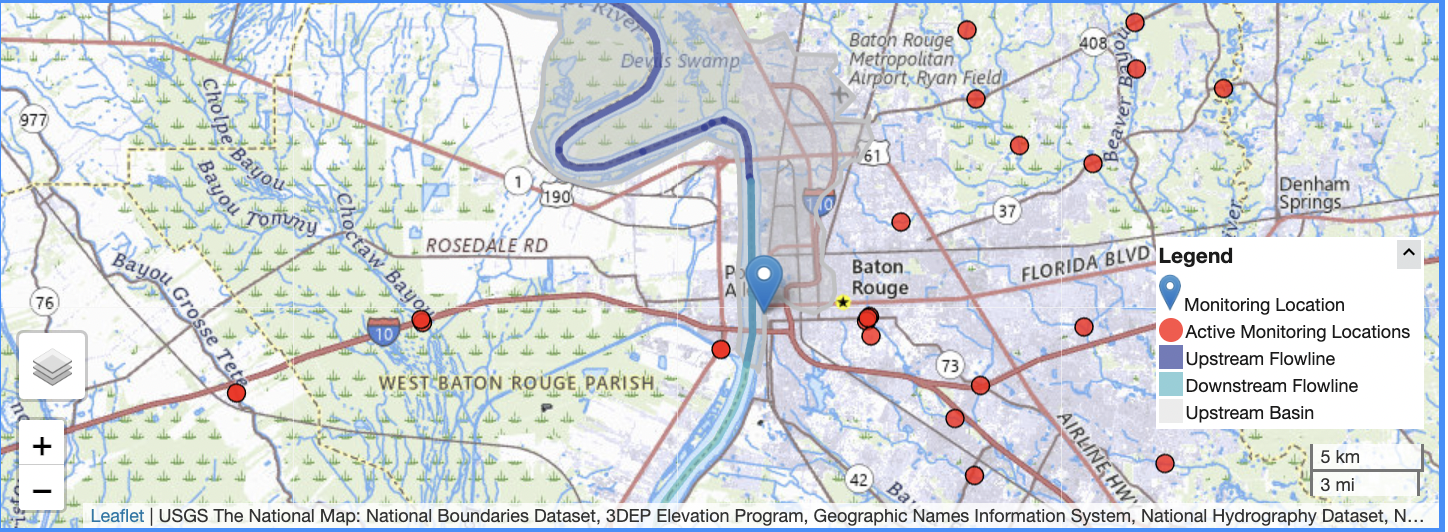
        

Data Used includes 
USGS: monitoring station gauge, Mississippi River at Baton Rouge, LA - USGS-07374000
*need sediment data (sediment load)/or sediment size correlation to turbidity (fine & coarse?)*

USGS original information  Data provided for site 07374000 in Baton Rouge, LA

*Gage (gauge) height matters because it is a measure of the water level (more accurate than measuring volume of water passing by/through a point in the river). The gauge height is used to calculate river discharge through a rating curve. 

River Discharge : the volume of water flowing per unit of time

Turbidity : a measure of how much suspended solid is in the water volume. In units of 1 NTU (Nephelometric Turbidity Unit), which is a measure of how much suspended particles are in the water volume, measured by a nephelometer, a scientific device that shoots a light beam at a 90 degree angle through the water and the light scatter is measured. The more scatter = higher NTU = higher turbidity 

            TS   parameter     statistic     Description

        215574       63680     00003     Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU) (Mean)

        215575       63680     00001     Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU) (Maximum)

        215576       63680     00002     Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU) (Minimum)

         61158       00065     00001     Gage height, feet (Maximum)

         61159       00065     00002     Gage height, feet (Minimum)

         61160       00065     00003     Gage height, feet (Mean)

         61176       00060     00003     Discharge, cubic feet per second (Mean)

#Imports

In [1]:
#Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as plotdate
import matplotlib.pyplot as plt
import sys 
import os
from pathlib import Path
folder_path = Path(os.getcwd()).parent.parent/'src'
sys.path.append(folder_path)
from scipy import stats

Parameters

In [2]:
#Parameters
cwd = os.getcwd()
data_usgs = Path(cwd)/ 'USGS data.txt'

in_to_cm = 2.54 #conversion of inch to cm 
sec_to_day = 60 * 60 * 24 #seconds in a day
ft3_to_m3 = 0.0283168 #conversion for ft3 to m3 
ft_to_m = 0.3048 #conversion from foot to m 
drainage_area = 1125810 #square miles
mi2_to_m2 = 2589988 #miles^2 to meters^2

reading in USGS data...
This function's purpose is to read in the USGS data from the Baton Rouge, LA monitoring gauge. The gauge's data includes: discharge (converted from ft3/s -> mm/day for the drainage area), turbidity (NTU), and gauge height (ft). The data in this function will be used in calcualtions and plotting further in along in the coding project. 

((ft^3/s)/miles^2) * (0.028m^3/1ft^3) * (1 mile^2/2,589,988m^2) * (24hrs*60mins*60secs) * (1000mm/1m)) = mm/day

In [3]:
#%%reading in USGS data
def read_in_usgs(filename):  
    """
    Parameters
    ----------
    filename : USGS data (in tab-deliminated form(txt))
    
    Returns   
    -------    
    dataframe with datetime as index, turbidity, gauge height, and discharge
    df with datetime index, discharge (ft3/s), gauge height (ft),
    turbidity (NTU), water year, and discharge converted to mm over drainage area)
    """
    #---read data in   
    
    usgs_data = pd.read_csv(filename, comment="#", sep="\t", skiprows=36) #want to skip lines until headings
    usgs_data = usgs_data.iloc[1:,:]
    
    #--convert datetime to index
    
    usgs_data["datetime"] = pd.to_datetime(usgs_data["datetime"], errors='coerce') #make datetime into real dates and time
    usgs_data.set_index("datetime", inplace=True) #set new index as datetime
    
    #---cols to keep that are needed (USGS codes for discharge,gauge height, turbidity)
    cols_to_keep = [] #to store cols I want 
    
    for name in usgs_data.columns.tolist():  # discharge
        if ((("00060" in name) or ("00065" in name) or ("63680" in name))
            and (("00003" in name) and ("cd" not in name))):
            cols_to_keep.append(name)    
    
             
    good_data= usgs_data[cols_to_keep].apply(pd.to_numeric, errors='coerce') #puts good columns in good_data df, also makes them numbers
            
    #----renaming cols 
    
    new_names = {} #makes it a "dictionary" to put new names in 
    for name in good_data.columns:
        if "00060" in name:
            new_names[name] = "discharge (ft^3/s)"
        elif "00065" in name:
            new_names[name] = "gauge height (feet)"
        elif "63680" in name:
            new_names[name] = "Turbidity"
        else:
            new_names[name] = name
            
    good_data.rename(columns=new_names, inplace=True)
    
    #----conversions 
    
    def vol_ft3_to_area_m(discharge_ft3s):
            vol_ft3 = discharge_ft3s * sec_to_day
            vol_m3 = discharge_ft3s * ft3_to_m3  # ft3 -> m3
            discharge_m = vol_m3 / (drainage_area/mi2_to_m2)# depth (m)
            discharge_mm = discharge_m * 10000
            return discharge_mm
       
    if "discharge (ft^3/s)" in good_data.columns:
        good_data["discharge_mm/day"] = vol_ft3_to_area_m(good_data["discharge (ft^3/s)"])
    
    #--water year conversion
     
    good_data['wateryear'] = np.where(good_data.index.month >= 10,
                            good_data.index.year +1,
                            good_data.index.year) #water year parameters, switch from month 9 to 10 
    
    #--gauge height conversion
    good_data['gauge height (m)'] = good_data['gauge height (feet)'] * ft_to_m
    
    return(good_data)

#---reassign dataframe, use good_data (more simplified)
good_data = read_in_usgs(data_usgs)

WORK IN PROGRESS !!!!!

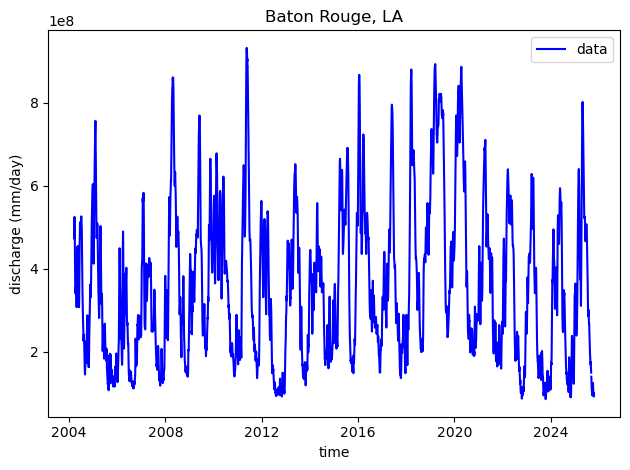

In [4]:
#%% Figure : time vs discharge (mm/day)
x = good_data.index
y = good_data['discharge_mm/day']

plt.figure()
plt.plot(x, y, color='blue', label="data")
plt.xlabel("time")
plt.ylabel("discharge (mm/day)")
plt.title("Baton Rouge, LA")
plt.legend()
plt.tight_layout()
plt.show()

Notes : 
EQUATION: TSS = 1.913 * Turbidity- 2.141  (Harringmeyer et al 2024)....
turbidity in formazin nephelometric units...
TSS = total suspended solids

In [5]:
#%%Concentration calculation  

good_data['tss'] = 1.913 * good_data['Turbidity'] - 2.141 #calculated tss from turbidity 


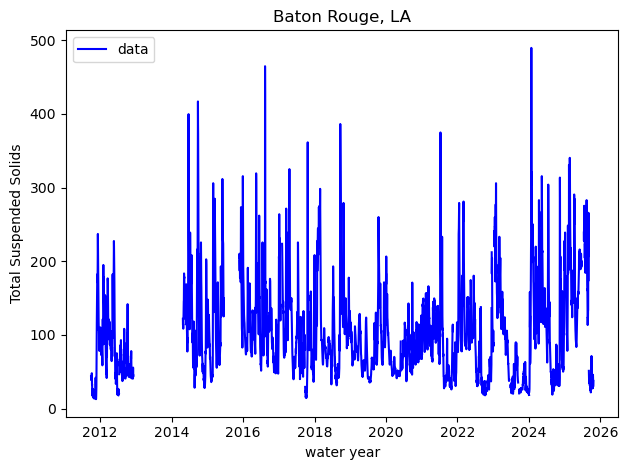

In [15]:
#%% Figure : TSS vs datetime

x = good_data.index
y = good_data['tss']

plt.figure()
plt.plot(x, y, color='blue', label="data")
plt.xlabel("water year")
plt.ylabel("Total Suspended Solids")
plt.title("Baton Rouge, LA")
plt.legend()
plt.tight_layout()
plt.show()

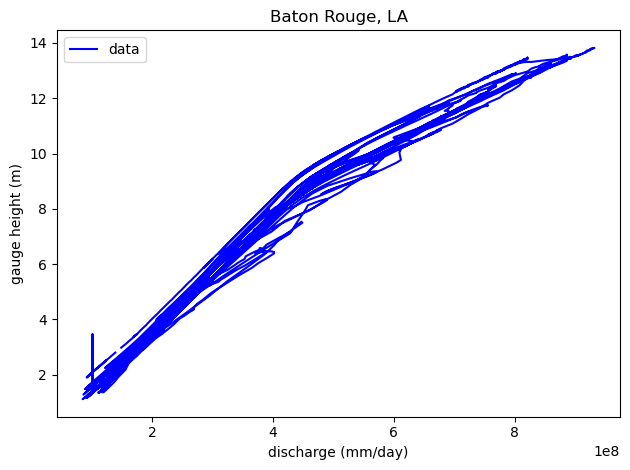

In [6]:
#%% Figure : gauge height vs discharge 

x = good_data['discharge_mm/day']
y = good_data['gauge height (m)']

plt.figure()
plt.plot(x, y, color='blue', label="data")
plt.xlabel("discharge (mm/day)")
plt.ylabel("gauge height (m)")
plt.title("Baton Rouge, LA")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#%%calculations

types = ['discharge_mm/day', 'gauge height (m)', 'tss'] #variables that calculations will be based off

for variables in types: 
    ################whole study (all years) calculations ,
    ###average across the whole study (all years)
    average_whole = good_data[variables].mean() #mean for all years
    min_whole = good_data[variables].min() #min for all years
    max_whole = good_data[variables].max() #max for all years 
 
    good_data[f'average of {variables} in whole study'] = average_whole
    good_data[f'minimum of {variables} in whole study'] = min_whole   
    good_data[f'maximum of {variables} in whole study'] = max_whole
    
    print(f"average {variables} across entire study: {average_whole:.3f}")
    print(f"minimum value {variables} across entire study {min_whole:.3f}")
    print(f"maximum value {variables} across entire study {max_whole:.3f}")
    
    ################ water year calculations
    ###average per water year 
    average_wy = good_data.groupby('wateryear')[variables].mean()
    min_wy = good_data.groupby('wateryear')[variables].min()
    max_wy = good_data.groupby('wateryear')[variables].max()
    
    print(f"average of {variables} across {average_wy}")
    print(f"maximum value {variables} across {max_wy}")
    print(f"minimum value {variables} across {min_wy}")
    
    average_wy = average_wy.drop(2026, errors='ignore') #dropping 2026 since it is not a full water year 
    min_wy = min_wy.drop(2026, errors='ignore')
    max_wy = max_wy.drop(2026, errors='ignore')
        
    #water year averages as a new column in good_data
    good_data[f'average of {variables} in wateryear'] = good_data['wateryear'].map(average_wy)
    good_data[f'minimum of {variables} in wateryear'] = good_data['wateryear'].map(min_wy)
    good_data[f'maximum of {variables} in wateryear'] = good_data['wateryear'].map(max_wy)
                                     

average discharge_mm/day across entire study: 360559372.920
minimum value discharge_mm/day across entire study 85339111.910
maximum value discharge_mm/day across entire study 931564351.389
average of discharge_mm/day across wateryear
2004    3.512992e+08
2005    3.332821e+08
2006    2.071447e+08
2007    3.028106e+08
2008    3.983328e+08
2009    3.437159e+08
2010    4.412236e+08
2011    3.754100e+08
2012    2.725117e+08
2013    3.311904e+08
2014    3.114739e+08
2015    3.853780e+08
2016    4.263218e+08
2017    3.584742e+08
2018    3.644015e+08
2019    6.181914e+08
2020    5.137772e+08
2021    3.689901e+08
2022    3.347082e+08
2023    2.732547e+08
2024    2.863095e+08
2025    3.439658e+08
2026    1.029281e+08
Name: discharge_mm/day, dtype: float64
maximum value discharge_mm/day across wateryear
2004    5.257150e+08
2005    7.556746e+08
2006    4.892341e+08
2007    5.823906e+08
2008    8.599056e+08
2009    7.687035e+08
2010    6.775013e+08
2011    9.315644e+08
2012    5.628473e+08
2013   

CHECK WITH ANNE ABOUT THIS CALCULATION & UNITS !!!

In [18]:
###flux = concentration x discharge, so sediment flux = tss x discharge (in per day) 
good_data['sediment_flux'] = good_data['tss'] * good_data['discharge_mm/day']
   

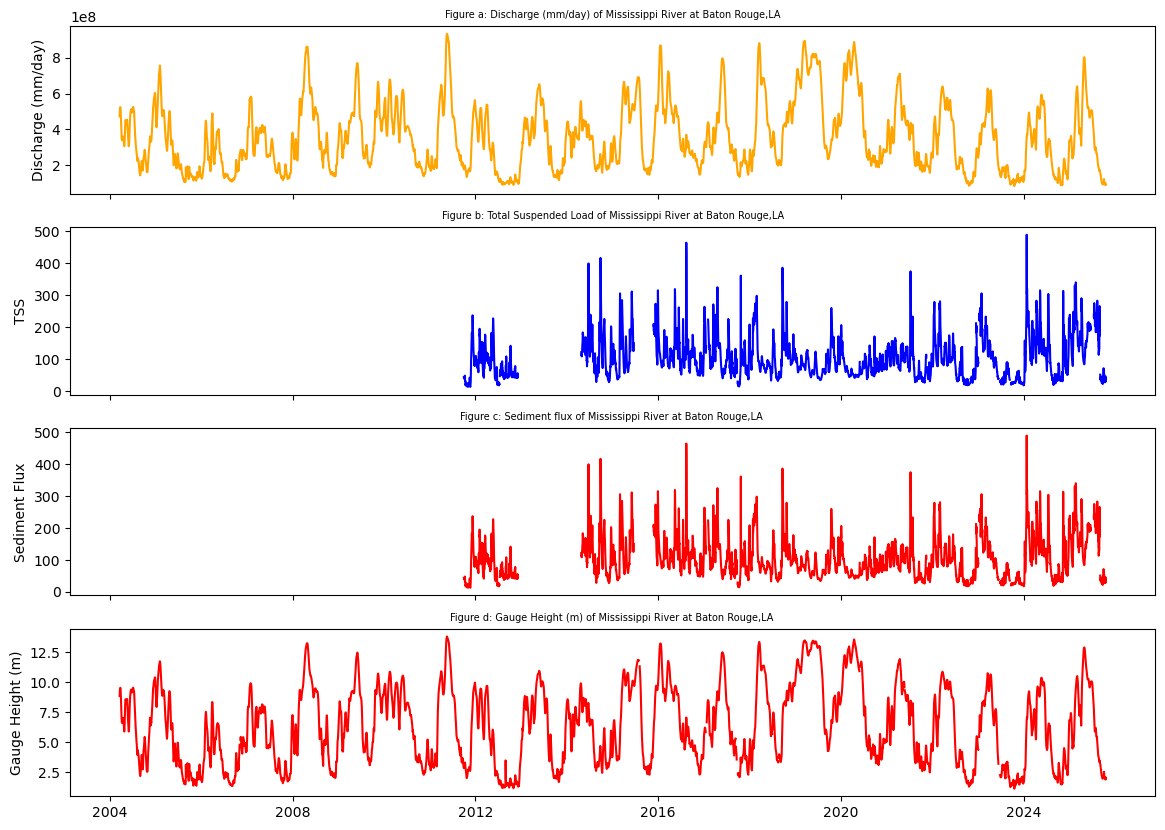

In [22]:
#%%Compiled timeseries figure : (A): Discharge (mm/day), (B): TSS, (C): Sediment Flux, (D): Gauge Height (m)

fig, axs = plt.subplots(4,1,figsize=(14, 10), sharex=True)
axs = axs.flatten()

axs[0].set_title("Figure a: Discharge (mm/day) of Mississippi River at Baton Rouge,LA",fontsize=7)
axs[0].plot(good_data.index, good_data["discharge_mm/day"], color="orange", label="Discharge (mm/day)")
axs[0].set_ylabel("Discharge (mm/day)")

axs[1].set_title("Figure b: Total Suspended Load of Mississippi River at Baton Rouge,LA",fontsize=7) #NEED UNITS and to be correct 
axs[1].plot(good_data.index, good_data["tss"], color="blue", label="TSS")
axs[1].set_ylabel("TSS")

axs[2].set_title("Figure c: Sediment flux of Mississippi River at Baton Rouge,LA ",fontsize=7) 
axs[2].plot(good_data.index, good_data["tss"], color="red", label="TSS") #NEED UNITS and to be correct 
axs[2].set_ylabel("Sediment Flux")

axs[3].set_title("Figure d: Gauge Height (m) of Mississippi River at Baton Rouge,LA ",fontsize=7) 
axs[3].plot(good_data.index, good_data["gauge height (m)"], color="red", label="Gauge Height (m)") #NEED UNITS and to be correct 
axs[3].set_ylabel("Gauge Height (m)")

plt.show()

In [23]:
#%% linear regression calculation 

def lin_reg(x,y, xlabel, ylabel, title):
    """
    scatter plot with regression
    best fit line calculated using linear and theil-sen techniques
    confidence interval for regression slope using linear and theil-sen technqiues 
    p value for linear and theil-sen techniques
    
    """
    new_df = pd.DataFrame({'x': x , 'y': y }).dropna()
    
    x_good = new_df['x'].values #no nans 
    y_good = new_df['y'].values #no nans
    
    #parametric linear regression
    lsq = stats.linregress(x_good, y_good)

    # Parametric Linear Regress
    lsq = stats.linregress(x_good, y_good)
    print(f"Parametric linear regression: {y_good} vs {x_good}")
    print(f"slope: {lsq.slope:.3f}")
    print(f"intercept: {lsq.intercept:.3f}")
    print(f"r-value: {lsq.rvalue:.3f}")
    print(f"p-value: {lsq.pvalue:.3e}")
    print(f"standard error: {lsq.stderr:.3f}")
    print(f"95% CI slope: [{lsq.slope - 2*lsq.stderr:.3f}, {lsq.slope + 2*lsq.stderr:.3f}]")

    # Nonparametric Theil–Sen Regression 
    ts = stats.theilslopes(y_good, x_good, 0.95)
    print(f"Theil–Sen regression:")
    print(f"slope: {ts.slope:.3f}")
    print(f"intercept: {ts.intercept:.3f}")
    print(f"95% CI slope: [{ts.low_slope:.3f}, {ts.high_slope:.3f}]")

    # Kendall Tau
    tau = stats.kendalltau(x_good, y_good)
    print(f"Kendall Tau correlation: {tau.statistic:.3f}")
    print(f"p-value: {tau.pvalue:.3e}")

    #Plot 
    plt.figure()
    plt.scatter(x_good, y_good, color='red', label='data')

    #Fit lines
    x_fit = np.linspace(np.min(x_good), np.max(x_good), 100)
    y_fit_lin = lsq.intercept + lsq.slope * x_fit
    y_fit_ts = ts.intercept + ts.slope * x_fit

    plt.plot(x_fit, y_fit_lin, color='blue', label='Linear regression (parametric)')
    plt.plot(x_fit, y_fit_ts, color='purple', linestyle='--', label='Theil–Sen (non-parametric)')

    plt.xlabel(xlabel if xlabel else x_good)
    plt.ylabel(ylabel if ylabel else y_good)
    plt.title(title if title else f"{y_good} vs {x_good}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

 Parametric linear regression: [8.863584 9.089136 9.238488 ... 2.020824 1.987296 1.901952] vs [4.72948055e+08 4.89885589e+08 5.00960130e+08 ... 9.83679840e+07
 9.64136532e+07 9.25049915e+07]
 slope: 0.000
 intercept: 0.210
 r-value: 0.985
 p-value: 0.000e+00
 standard error: 0.000
 95% CI slope: [0.000, 0.000]
 Theil–Sen regression:
 slope: 0.000
 intercept: -0.285
 95% CI slope: [0.000, 0.000]
 Kendall Tau correlation: 0.971
  p-value: 0.000e+00


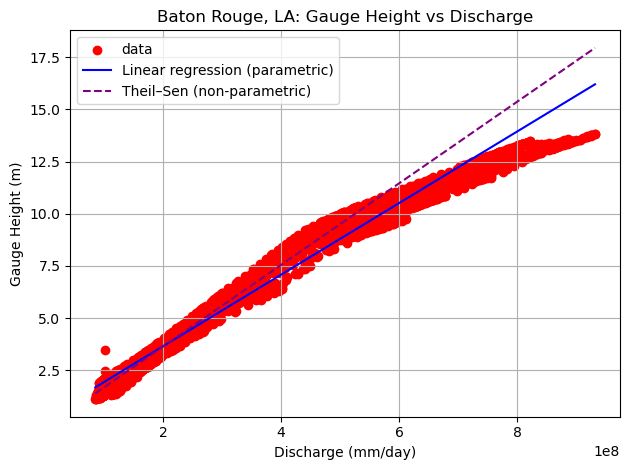

In [24]:
# Figure: Gauge height vs discharge
lin_reg(good_data['discharge_mm/day'], good_data['gauge height (m)'],
        xlabel='Discharge (mm/day)', ylabel='Gauge Height (m)',
        title='Baton Rouge, LA: Gauge Height vs Discharge')

 Parametric linear regression: [43.5797 38.7972 40.7102 ... 29.8061 33.6321 37.6494] vs [1.77844103e+08 1.78495547e+08 1.81101321e+08 ... 9.83679840e+07
 9.64136532e+07 9.25049915e+07]
 slope: 0.000
 intercept: 76.924
 r-value: 0.223
 p-value: 3.895e-50
 standard error: 0.000
 95% CI slope: [0.000, 0.000]
 Theil–Sen regression:
 slope: 0.000
 intercept: 46.649
 95% CI slope: [0.000, 0.000]
 Kendall Tau correlation: 0.294
  p-value: 1.133e-185


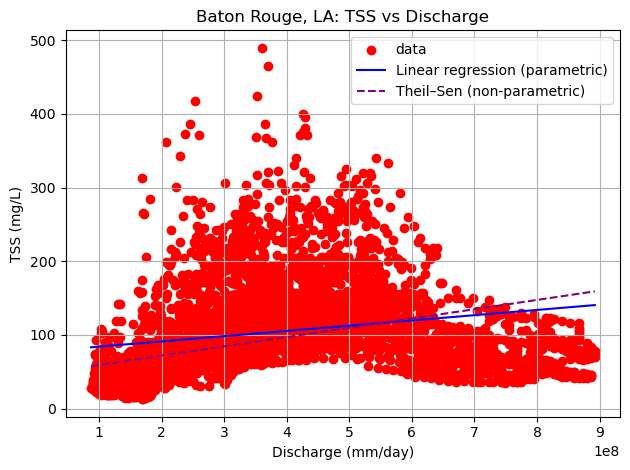

In [25]:
# Figure: TSS vs discharge
lin_reg(good_data['discharge_mm/day'], good_data['tss'],
        xlabel='Discharge (mm/day)', ylabel='TSS (mg/L)',
        title='Baton Rouge, LA: TSS vs Discharge')

 Parametric linear regression: [7.75039267e+09 6.92512744e+09 7.37267102e+09 ... 2.93196597e+09
 3.24259362e+09 3.48275743e+09] vs [1.77844103e+08 1.78495547e+08 1.81101321e+08 ... 9.83679840e+07
 9.64136532e+07 9.25049915e+07]
 slope: 102.016
 intercept: 3397985563.133
 r-value: 0.633
 p-value: 0.000e+00
 standard error: 1.893
 95% CI slope: [98.231, 105.802]
 Theil–Sen regression:
 slope: 120.616
 intercept: -3571468027.768
 95% CI slope: [117.352, 123.898]
 Kendall Tau correlation: 0.612
  p-value: 0.000e+00


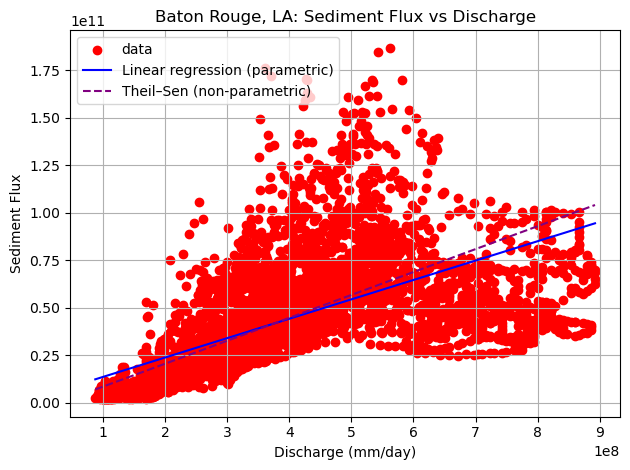

In [26]:
# Figure: Sediment flux vs discharge
lin_reg(good_data['discharge_mm/day'], good_data['sediment_flux'],
        xlabel='Discharge (mm/day)', ylabel='Sediment Flux',
        title='Baton Rouge, LA: Sediment Flux vs Discharge')

Find the turbidity correlation between grain size and suspended sediment

plot  of Time with discharge (m3/s) on x axis, concentration on y

Time series plot with discharge (m3/s), suspended load (g/m3), sed flux (g/s) 

plot with the annual sediment flux (relates to how much sediment is getting deposited in the GOM)

plot with seasonality of sed flux (is there one? or could the lock and dams be disrupting too much, is there a cyclical pattern shown (lock open or closed)? more flux during a certain season? Do I want a line chart or polar plot??

plot of various sediment grain sizes (ex:coarse and fine) and their correlated amounts with turbidity data that will be used for determining sediment load 

Potenial summarized results section:

Discussion : Jupyter notebook contains a markdown cell with an outline for the planned discussion and/or
    conclusion. Eventually, these sections should describe important trends and patterns that the analysis 
    reveals in your data, should consider your results in the context of previous work at other sites and/or
    produced by other analytical techniques, should describe any unexpected findings, should consider ways to 
    reduce errors or improve method, and should summarize and consider implications of your main findings. 
    Discuss whether the data support the hypothesis and the expectations that were described in the introduction.
    Explain conclusions that can be made from the results and the significance of these conclusions to other 
    scientists or watershed managers.
